# 1. Imports

In [1]:
# importing other dependencies
import numpy as np
import pandas as pd
# importing PyTorch
import torch
# importing torch.nn Module
import torch.nn as nn
# to load the activation functions
import torch.nn.functional as F
# importing Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, TensorDataset
# create datasets using `ImageFolder`
from torchvision.datasets import ImageFolder
# import compose and other transformations
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop
# plotting
import matplotlib.pyplot as plt


# for file paths
import os
# for time
import time
# for copying
import copy

In [2]:
# checks whether MPS is available
print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

# setting the device to "mps" instead of default "cpu"
device = torch.device("mps" if torch.backends.mps.is_available else "cpu")

True
True


In [3]:
# training on GPU
device

device(type='mps')

# 2. Preparing Data

In [4]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, Resize, CenterCrop, ToTensor, Normalize

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    # train transform
    'train': Compose([
        RandomResizedCrop(224),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean, std)
    ]),
    # test transform
    'test': Compose([
        Resize(256),
        RandomResizedCrop(224),
        ToTensor(),
        Normalize(mean, std)
    ])
}

In [5]:
data_dir = os.path.join('data','smp_clf_data')
data_dir

'data/smp_clf_data'

In [6]:
# some hyper-parameters
batch_size = 5
num_epochs = 30
learning_rate = 0.001

In [7]:
# create datasets using `ImageFolder`

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

image_datasets = {x:ImageFolder(root= os.path.join(data_dir, x), transform=data_transforms[x])
                for x in ['train', 'test']}

image_dataloaders = {'train':DataLoader(
                        dataset=image_datasets['train'],
                        batch_size=batch_size,
                        shuffle=True,
                    ),
                     'test':DataLoader(
                        dataset=image_datasets['test'],
                        batch_size=len(image_datasets['test']),
                        shuffle=True,
                    )}

data_sizes = {x:len(image_datasets[x])
                for x in ['train', 'test']}

class_names = image_datasets['train'].classes
print("Class Names:", class_names)

Class Names: ['non_smp', 'smp']


In [8]:
# extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))
# move the data to GPU
X_test, y_test = X_test.to(device), y_test.to(device)
# print the shape
print(X_test.shape, y_test.shape)

/Users/sampadk04/Desktop/Coding/environments/pip_envs/base_env/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


torch.Size([230, 3, 224, 224]) torch.Size([230])


In [9]:
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= " + class_names[y_test[i]])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 3. Model-1

In [15]:
from sklearn.metrics import accuracy_score

def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20):
    # begin start time to record time-elapsed
    # since = time.time()

    # to return the model with best accuracy
    # variable to store the best model parameters
    best_model_params = copy.deepcopy(model.state_dict())
    # variable to store the best accuracy
    best_acc = 0.0

    # start training epochs
    for epoch in range(num_epochs):

        # each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase=='train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
            
            # iterate over data
            for batch in image_dataloaders[phase]:
                # extract features and labels
                X,y = batch
                # adding to GPU
                X,y = X.to(device), y.to(device)

                # forward
                # track grad iff phase == train
                with torch.set_grad_enabled(phase=='train'):
                    # compute prediction
                    y_pred = model(X)

                    # loss + backward + optimize iff phase = 'train'
                    if phase=='train':
                        # compute loss
                        loss = criterion(y_pred, y)
                        # compute grads
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # zero-gradients after updating
                        optimizer.zero_grad()
                
            # learning scheduler step iff phase == 'train'
            if scheduler and phase=='train':
                # update learning rate
                scheduler.step()
            
            # check accuracy on test set iff phase == 'test'
            if phase=='test':
                _, y_hat = torch.max(y_pred, dim=1)
                epoch_acc = accuracy_score(y.cpu(), y_hat.cpu())

        # update best_model and best accuracy after the epoch
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_model_params = copy.deepcopy(model.state_dict())
        
        # print epoch info
        print('-----------------------------------------')
        print('Epoch: {}/{}'.format(epoch+1, num_epochs))
        print('Best Test Acc: {:2f}'.format(best_acc))
        # to keep track of time
        '''
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        '''
    

    # post training, load the best_model parameters and output the model

    # load best model weights
    model.load_state_dict(best_model_params)
    return model


In [11]:
from torchvision import models

model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze all the layers except the final FC Layer
for params in model2.parameters():
    params.requires_grad=False

# parameters of newly constructed modules have `required_grad=True` by default
# extract the input features taken in by the last FC layer
fc_inp_size = model2.fc.in_features
# reset the fc layer
model2.fc = nn.Linear(fc_inp_size, len(class_names))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sampadk04/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
# define parameters for training

# add model to GPU
model = model2.to(device)

# define loss
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr = learning_rate,
    momentum=0.9
)

# step Learning Rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10,
    gamma=0.5
)

In [14]:
# we also check the initial accuracy on the test data before training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Initial Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Initial Accuracy on test data: 0.40869565217391307


In [19]:
model = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
)

/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 1/30
Best Test Acc: 0.952174


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 2/30
Best Test Acc: 0.956522


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 3/30
Best Test Acc: 0.969565


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 4/30
Best Test Acc: 0.982609


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 5/30
Best Test Acc: 0.982609


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 6/30
Best Test Acc: 0.982609


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 7/30
Best Test Acc: 0.982609


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 8/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 9/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 10/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 11/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 12/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 13/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 14/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 15/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 16/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 17/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 18/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 19/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 20/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 21/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 22/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 23/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 24/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 25/30
Best Test Acc: 0.986957


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 26/30
Best Test Acc: 0.991304


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 27/30
Best Test Acc: 0.991304


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 28/30
Best Test Acc: 0.991304


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 29/30
Best Test Acc: 0.991304


/Volumes/SKK-T7/Apps/conda_envs/conda_pytorch_env/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


-----------------------------------------
Epoch: 30/30
Best Test Acc: 0.991304


In [20]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.9695652173913043


In [15]:
model1_save_path = os.path.join('models','model1_mps.pth')
model1_save_path

'models/model1_mps.pth'

In [22]:
#torch.save(model, model1_save_path)

In [16]:
model_main = torch.load(model1_save_path)

In [17]:
# we also check the final accuracy on the test data after training

from sklearn.metrics import accuracy_score

with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model_main(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)
    # push the matrices back to cpu from gpu
    y_test_hat_cpu = y_test_hat.cpu()
    y_test_cpu = y_test.cpu()
    print("Final Accuracy on test data:", accuracy_score(y_test_cpu, y_test_hat_cpu))

Final Accuracy on test data: 0.9739130434782609


# 4. Visualization

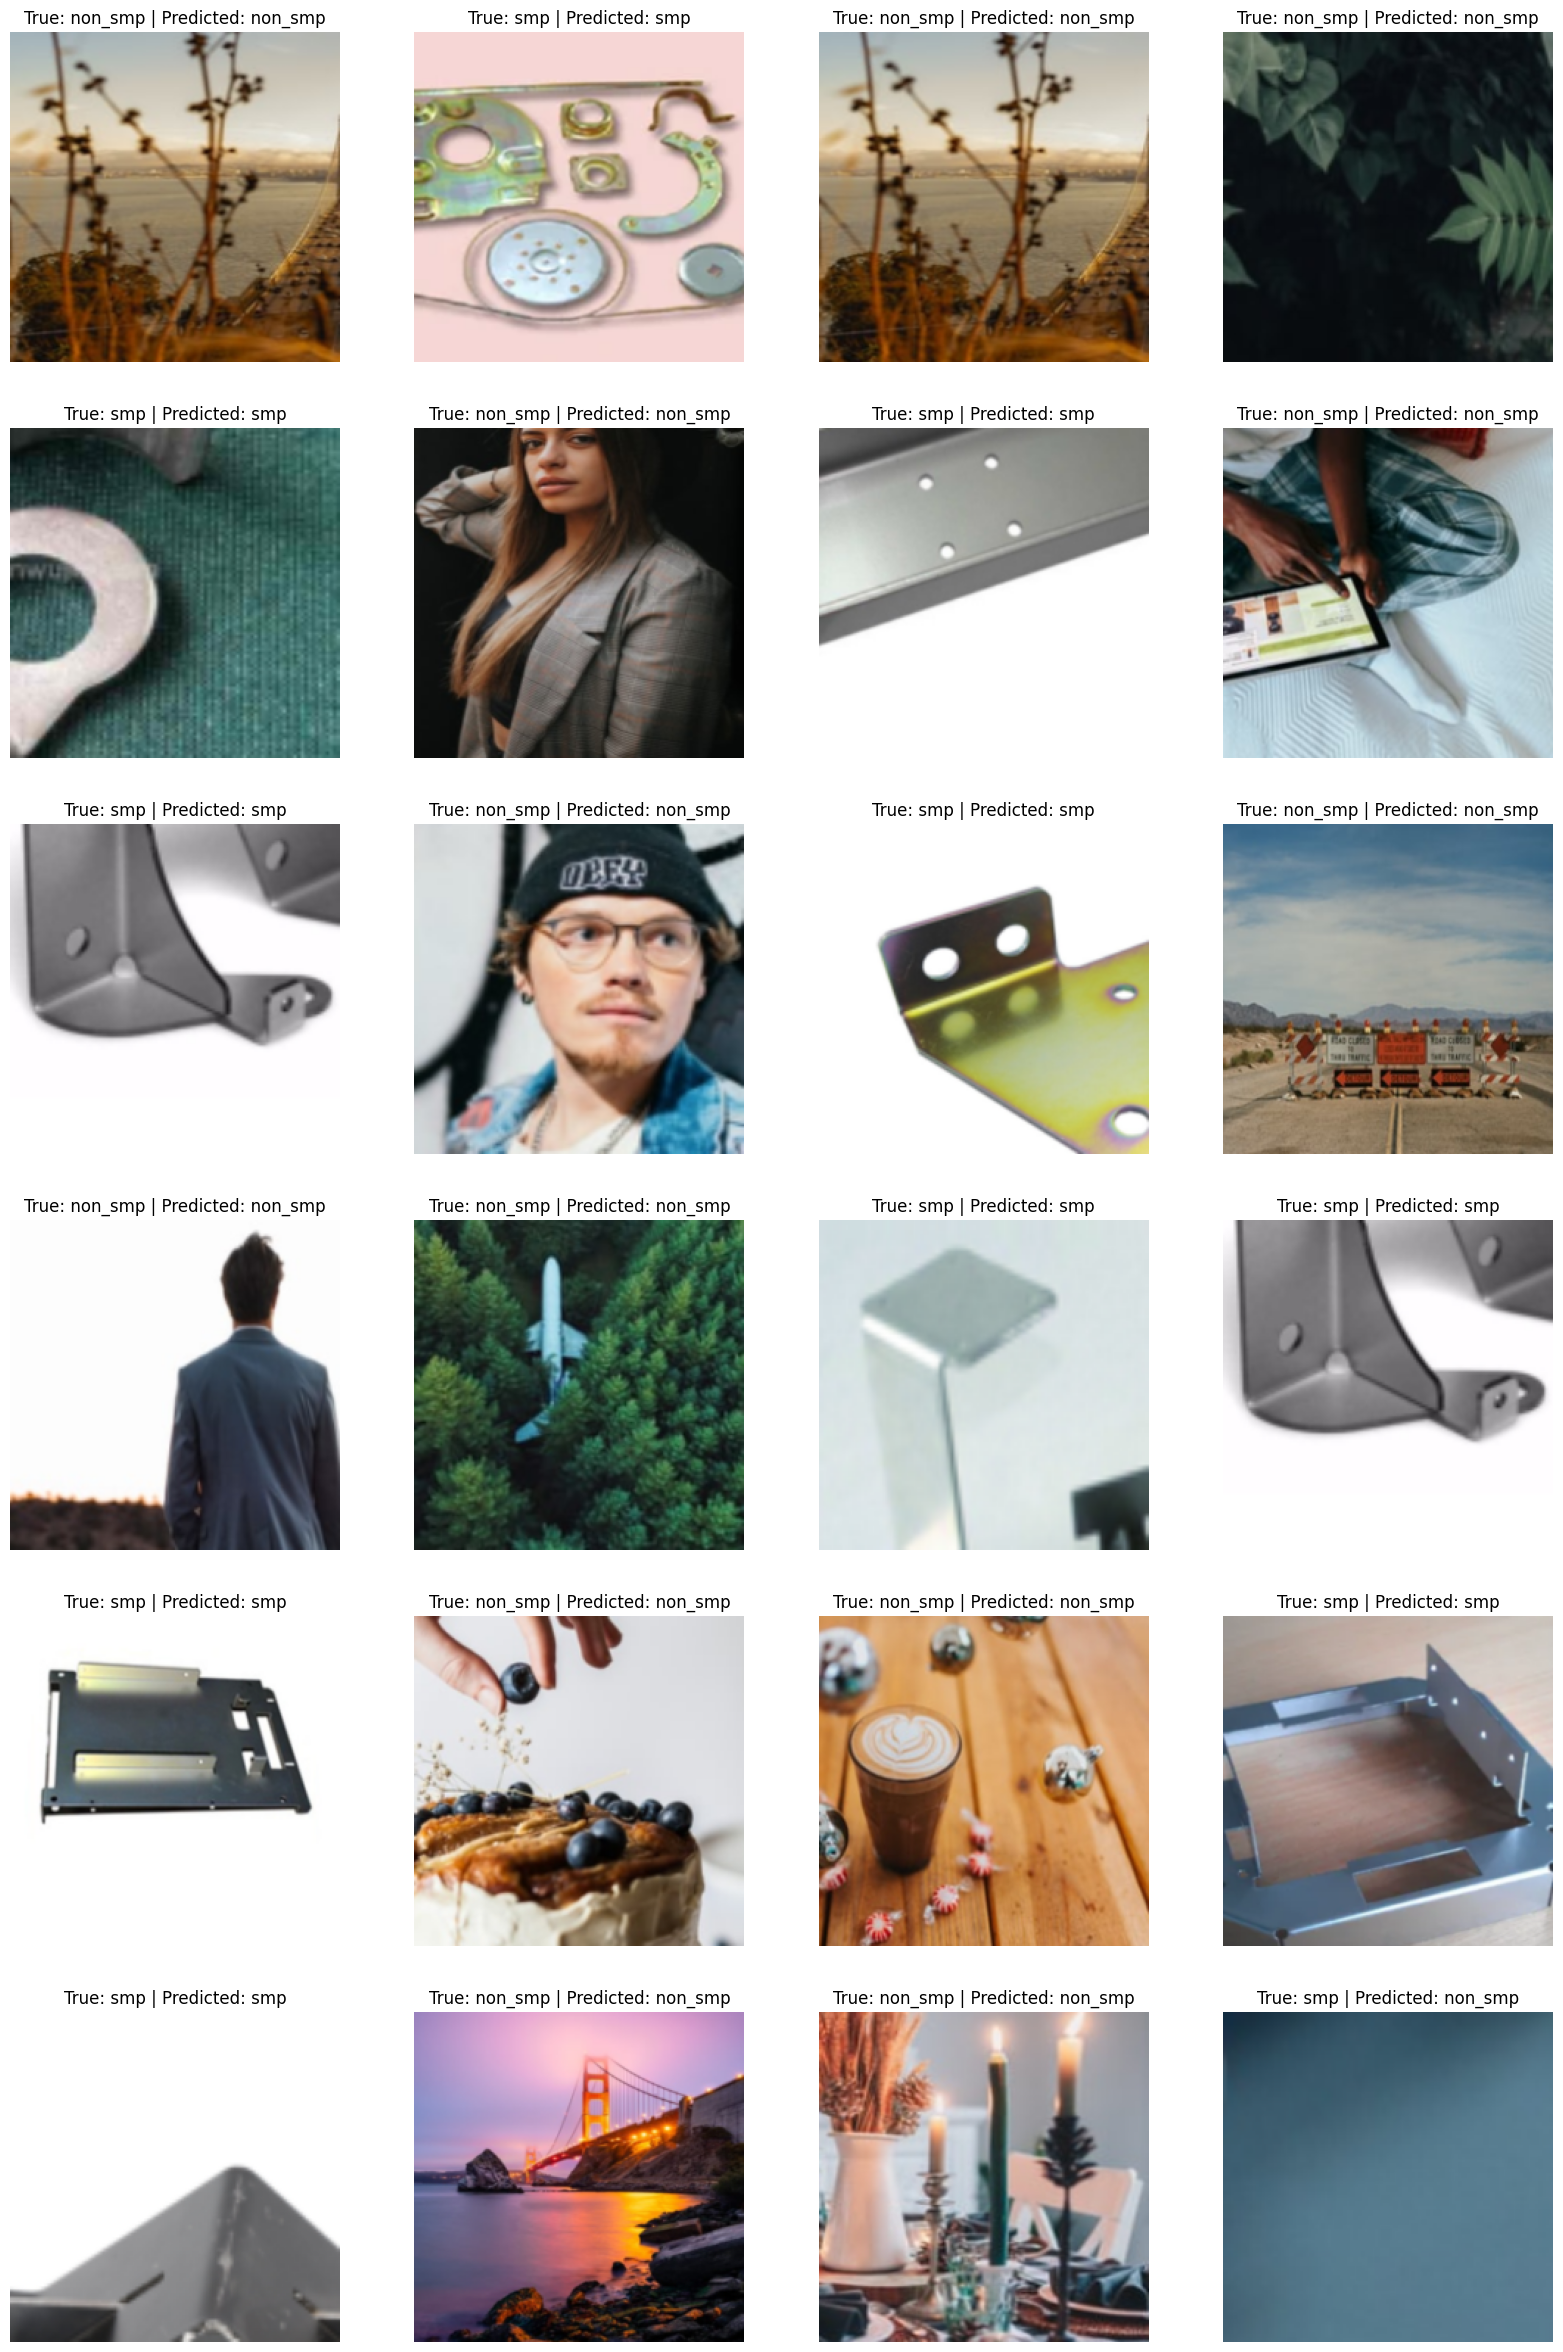

In [19]:
with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model_main(X_test)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)


test_idx = np.random.randint(X_test.shape[0] ,size=24)

plt.figure(figsize=(20,30))
for i in range(24):
    plt.subplot(6, 4, i+1)
    # copy the image back to cpu to reshape
    img = X_test[test_idx[i]].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("True: " + class_names[y_test[test_idx[i]]] + " | Predicted: " + class_names[y_test_hat[test_idx[i]]])
    plt.grid(False)
    plt.axis(False)
plt.show()

# 5. Testing

In [20]:
test_dir = os.path.join('data', 'Testing')
test_dir

'data/Testing'

In [21]:
testing_dataset = ImageFolder(root=test_dir, transform = data_transforms['test'])

testing_img_loader = DataLoader(dataset=testing_dataset, batch_size = len(testing_dataset), shuffle=False)

imgs, target = next(iter(testing_img_loader))
imgs, target = imgs.to(device), target.to(device)

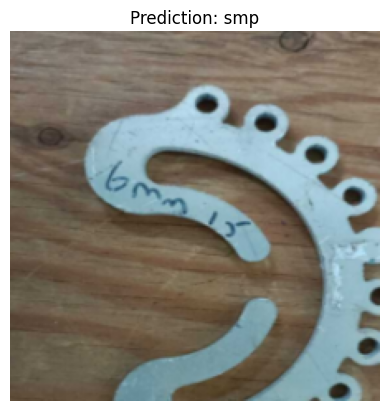

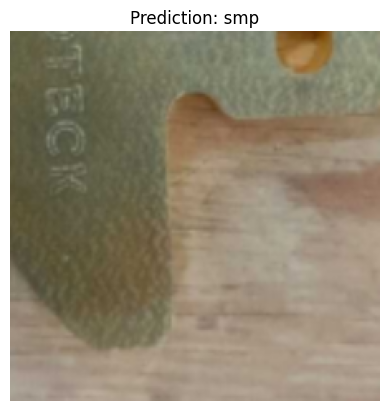

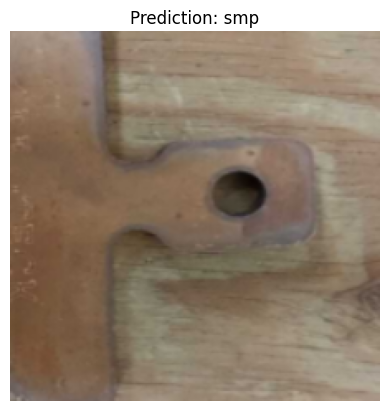

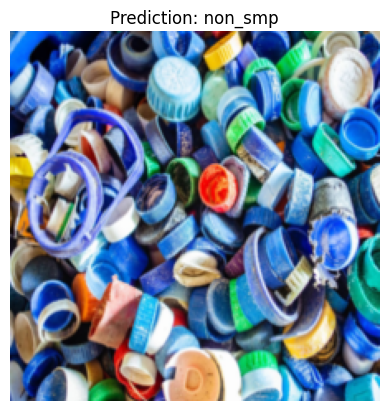

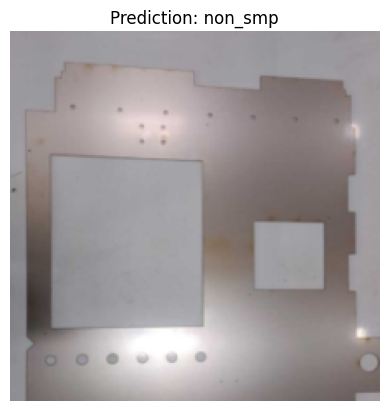

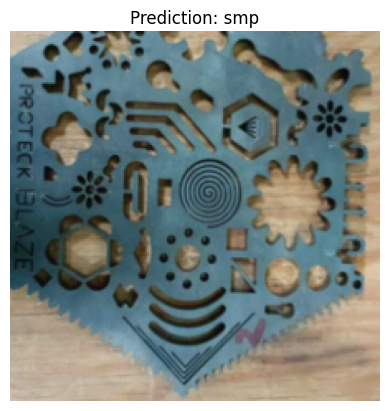

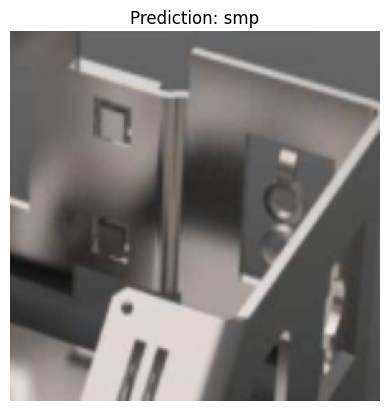

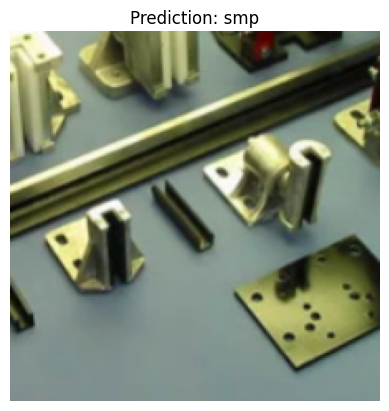

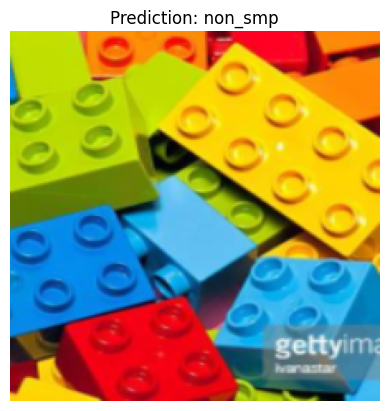

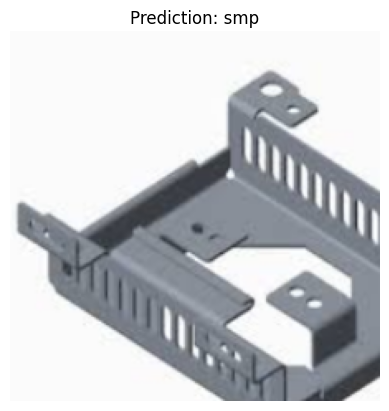

In [22]:
with torch.no_grad():
    # this gives the sigmoid output
    y_test_pred = model_main(imgs)
    # this gives the index of the max column per row
    _ , y_test_hat = torch.max(y_test_pred, dim=1)


for i in range(imgs.shape[0]):

    plt.figure()
    # copy the image back to cpu to reshape
    img = imgs[i].cpu()
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
        
    plt.imshow(img)
    plt.title("Prediction: " + class_names[y_test_hat[i]])
    plt.grid(False)
    plt.axis(False)
    plt.show()